## Apply Deep Learning Transformer Architecture



## Load Libraries

In [4]:
!pip -q install mlflow

In [23]:
import os
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from tokenizers import BertWordPieceTokenizer
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers
from transformers import TFDistilBertModel

import mlflow
import mlflow.tensorflow

import matplotlib.pyplot as plt

## Load Datasets

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
os.chdir("/content/drive/Othercomputers/My Mac/Documents/datascience_projects/my_kedro_sklearn_nlp/toxic-comment-classification-kedro/notebooks")

In [8]:
train_df = pd.read_csv("../data/01_raw/jigsaw-toxic-comment-train.csv")
val_df = pd.read_csv("../data/01_raw/validation.csv")
test_df = pd.read_csv("../data/01_raw/test.csv")

## Preprocessing - Tokenizer

In [9]:
devices = tf.config.list_physical_devices()
for device in devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [10]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
AUTO = tf.data.experimental.AUTOTUNE

# Hyperparameters setups
EPOCHS=2
BATCH_SIZE= 512
MAX_LEN = 512

In [12]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer.save_pretrained("../data/05_model_input")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

('../data/05_model_input/tokenizer_config.json',
 '../data/05_model_input/special_tokens_map.json',
 '../data/05_model_input/vocab.txt',
 '../data/05_model_input/added_tokens.json')

In [13]:
fast_tokenizer = BertWordPieceTokenizer("../data/05_model_input/vocab.txt")
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [14]:

def encoded(texts: list, tokenizer: BertWordPieceTokenizer, chunk_size=256, maxlen=512)-> np.array:
    """

    Args:
        texts (list): all the input samples that will be used for tokenization
        tokenizer (BertWordPieceTokenizer): Distil-BERT tokenizer
        chunk_size (int, optional): The batch_size that will be passed for tokenization. Defaults to 256.
        maxlen (int, optional): Dimensions of the embeddings returned in the tokenization process. Defaults to 512.

    Returns:
        np.array: the array_id returned after preprocess
    """

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []

    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].to_list()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])

    return np.array(all_ids)

In [15]:
X_train = encoded(train_df.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
y_train = train_df.toxic.values
X_val = encoded(val_df.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
y_val = val_df.toxic.values
X_test = encoded(test_df.content.astype(str), fast_tokenizer, maxlen=MAX_LEN)

  0%|          | 0/874 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [16]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (X_train, y_train)
    ).repeat(

    ).shuffle(
        1000
    ).batch(
        BATCH_SIZE
    ).prefetch(
        AUTO
    )
)

val_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_val, y_val))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

## Build DL Transformer Model & Start Training

In [17]:
def f1_score(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """Compute the F1 score for binary classification

    Args:
        y_true (tf.Tensor): Ground truth labels, a tensor containing binary values (0 or 1).
        y_pred (tf.Tensor): Predicted probabilities, a tensor with values in the range [0, 1]

    Returns:
        tf.Tensor: The F1 score computed as the harmonic mean of precision and recall (sentivity)
    """

    y_pred = tf.round(y_pred)
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(
        tf.cast(
            y_true * y_pred, tf.float32
        )
    )
    fp = tf.reduce_sum(
        tf.cast(
            (1 - y_true) * y_pred, tf.float32
        )
    )
    fn = tf.reduce_sum(
        tf.cast(
            y_true * (1 - y_pred), tf.float32
        )
    )

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1



In [18]:
class DistilBertLayer(Layer):
    def __init__(self, **kwargs):
        super(DistilBertLayer, self).__init__(**kwargs)
        self.transformer_layer = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

    def call(self, inputs):
        # Forward pass through DistilBERT
        output = self.transformer_layer(input_ids=inputs)[0]  # Sequence output
        return output

# Function to build the model
def build_model(max_len=512) -> Model:
    """Function for get the BERT training model

    Args:
        transformer (TFDistilBertModel): Pretrained model
        max_len (int, optional): Number of dimensions of the last layer of pretrained model. Defaults to 512.

    Returns:
        Model: Keras Model compiled
    """
    input_word_ids = Input(
        shape=(max_len,),
        dtype=tf.int32,
        name="input_word_ids"
    )

    sequence_output = DistilBertLayer()(input_word_ids)

    cls_token = sequence_output[:, 0, :]

    out = Dense(1, activation="sigmoid")(cls_token)

    model = Model(inputs=input_word_ids, outputs=out)

    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [27]:
model = build_model(MAX_LEN)

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_word_ids (InputLayer)          │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ distil_bert_layer_2                  │ (None, 512, 768)            │               0 │
│ (DistilBertLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_2 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
def train_log_with_mlflow():
    mlflow.set_experiment(
        "Applying Kedro Orchestration Pipelines to Deploy a Deep Learning Transformer Architecture for the Toxic Comment Classification Problem"
    )

    with mlflow.start_run():
        mlflow.log_param("batch_size", BATCH_SIZE)
        mlflow.log_param("epochs", EPOCHS)
        mlflow.log_param("learning_rate", 1e-5)

        mlflow.tensorflow.autolog()

        n_steps = X_train.shape[0] // BATCH_SIZE

        train_history = model.fit(
            train_dataset,
            steps_per_epoch=n_steps,
            validation_data=val_dataset,
            epochs=EPOCHS

        )


        plt.figure(figsize=(10, 6))
        plt.plot(train_history.history['accuracy'], label='Train Accuracy')
        plt.plot(train_history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

        mlflow.log_figure(plt.gcf(), "accuracy_plot.png")

        for epoch, accuracy in enumerate(train_history.history["accuracy"]):
            mlflow.log_metric(f"train_accuracy_epoch_{epoch}", accuracy)

        for epoch, accuracy in enumerate(train_history.history["val_accuracy"]):
            mlflow.log_metric(f"val_accuracy_epoch_{epoch}", accuracy)

        mlflow.tensorflow.log_model(model, artifact_path="distilbert_model", registered_model_name="DistilBERT_Toxic_Comment_Classification")

        print(f"RUN ID: {mlflow.active_run().info.run_id}")

Epoch 1/2
436/436 ━━━━━━━━━━━━━━━━━━━━ 224s 494ms/step - accuracy: 0.9034 - loss: 0.5039 - val_accuracy: 0.8462 - val_loss: 0.4474
Epoch 2/2
436/436 ━━━━━━━━━━━━━━━━━━━━ 210s 481ms/step - accuracy: 0.9034 - loss: 0.3822 - val_accuracy: 0.8462 - val_loss: 0.4293


2024/12/17 23:25:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='batch_size' was already logged with value='512' for run ID='fd53d866018d4f9091c3fc412887142f'. Attempted logging new value 'None'.


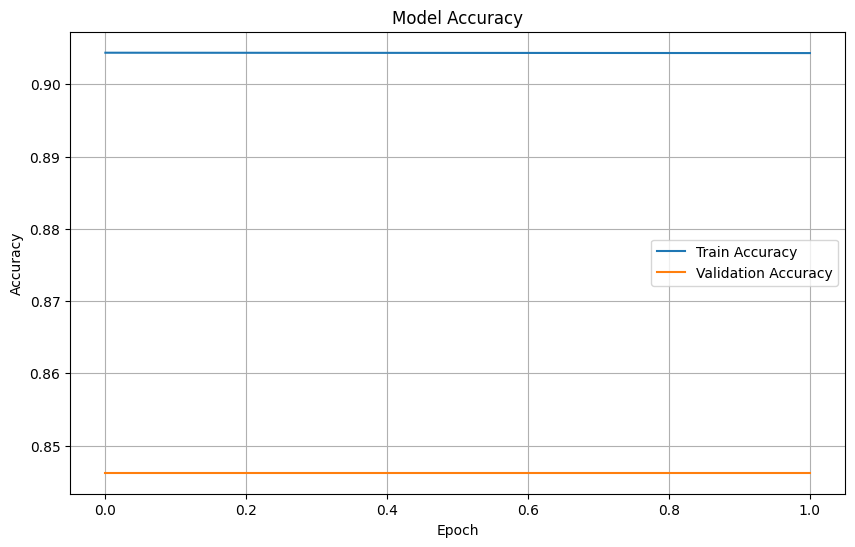

2024/12/17 23:25:19 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/12/17 23:25:27 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpi7q5ebot/model, flavor: tensorflow). Fall back to return ['tensorflow==2.17.1', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 
2024/12/17 23:25:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'DistilBERT_Toxic_Comment_Classification'.
Created version '1' of model 'DistilBERT_Toxic_Comment_Classification'.


RUN ID: fd53d866018d4f9091c3fc412887142f


<Figure size 640x480 with 0 Axes>

In [29]:
train_log_with_mlflow()

In [30]:
model.save("../data/06_models/toxic_comment_classification_model.keras")